# Gradient Boosting vs AdaBoost
* Gradient Boosting ve AdaBoost, makine öğrenmesinde kullanılan iki önemli boosting algroitmasıdır. İkisi de zayıf öğrenicileri(genellikle karar ağaçları) birleştirerek güçlü bir öğrenici oluşturmayı amaçlar

## AdaBoost(Adaptive Boosting)
### Çalışma Prensibi
** Başlangıçta tüm örneklere eşit ağırlık verilir

** Her yinelemede 

* Mevcut ağırlıklara göre zayıf bir öğrenici eğitilir
* Yanlış sınıflandırılan örneklerin ağırlıkları arttırılır
* Doğru sınıflandırılan örneklerin ağırlıkları azaltılır

** Her zayıf öğreniciye performansına göre bir ağırlık atanır

** Son tahmin, tüm zayıf öğrenicilerin ağırlıklı oylaması ile yapılır

### Kullanım Alanları

* Yüz tanıma sistemleri
* Müşteri segmentasyonları
* Kredi rish değerlendirmesi
* Anomali tespiti
* İkili sınıflandırma problemleri

## Gradient Boosting
### Çalışma Prensibi
** İlk zayıf öğrenici basit bir tahmin yapar(örneğin ortalama değer)

** Her yinemelede :

* Önceki modelin hatalarını(artıklarını hesaplar)
* Bu hataları tahmin etmek için yeni bir zayıf öğrenici eğitilir
* Yeni öğrenici, önce modele bir öğrenme oranı(learning rate) ile eklenir

** Son model tüm zayıf öğrenicilerin toplamıdır

### Kullanım Alanı

* Satış/fiyat tahmini
* Öneri sistemleri
* Finansal risk modellemesi
* Çok sınıflı sınıflandırma ve regresyon problemleri
* İlaç keşfi ve genomik veriler

## Temel Farkları

** Özellikleri

* AdaBoost; yanlış sınıflandırılan örneklerin ağırlıklarını arttırır
* Gradient Boosting; önceki modelin hatalarını(artıklarını) modeller

** Kayıp Fonksiyonu

* AdaBoost; genellikle üstsel kayıp
* Gradient Boosting; çeşitli kayıp fonksiyonları kullanılabilir(MSE,MAE,log-loss ..)

** Esneklik

* AdaBoost; daha az parametre
* Gradient Boosting; daha fazla parametre ve ayarlama 

** Aşırı öğrenme riski

* AdaBoost; daha düşük
* Gradient Boosting; daha yüksek(ayarlama gerektirir)

** Kullanım Alanları

* AdaBoost; Sınıflandırma
* Gradient Boosting; Sınıflandırma ve regresyon

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score, classification_report,mean_squared_error
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")

# Örnek 1-) AdaBoost ile Müşteri Churn Tahmini

In [106]:
# Örnek veri oluştur(gerçek bir şirketteki müşteri verilerine benzer olsun)
np.random.seed(31)
n_samples=1000

#Müşteri özellikleri
tenure=np.random.randint(1,73,n_samples) #Müşteri kaç aydır üye
monthly_charges=np.random.uniform(20,120,n_samples) #Aylık ödeme
total_charges=tenure*monthly_charges + np.random.normal(0,100,n_samples)#Toplam ödeme.Zamlar ya da indirimler eklendi
contract_type=np.random.choice(["Month-to-month","One year","Two year"],n_samples)
online_security=np.random.choice(["Yes","No"],n_samples)
tech_support=np.random.choice(["Yes","No"],n_samples)
payment_method=np.random.choice(["Electronic check","Mailed check","Bank transfer","Credit card"],n_samples)

#Churn durumu(hedef değişkeni):Uzun süreli veya yüksek ödemeli müşterilerin daha az churn yapmasını sağla
churn_prob=1 / (1+np.exp(0.1 * tenure + 0.01 *monthly_charges -2 ))
churn=np.random.binomial(1,churn_prob)

In [107]:
#DataFrame oluştur
data=pd.DataFrame({"Tenure":tenure,
                   "MonthlyCharges":monthly_charges,
                   "TotalCharges":total_charges,
                   "ContractType":contract_type,
                   "OnlineSecurity":online_security,
                   "TechSupport":tech_support,
                   "PaymentMethod":payment_method,
                   "Churn":churn})
data.head(3)

,Tenure,MonthlyCharges,TotalCharges,ContractType,OnlineSecurity,TechSupport,PaymentMethod,Churn
0,17,74.692446,1113.359777,One year,Yes,Yes,Electronic check,0
1,24,60.775699,1436.547548,One year,No,No,Credit card,0
2,59,77.266382,4410.690883,Two year,Yes,Yes,Mailed check,0


In [108]:
#Kategorik değişkenleri dönüştürme
categorical_cols=["ContractType","OnlineSecurity","TechSupport","PaymentMethod"]
for i in categorical_cols:
    le=LabelEncoder()
    data[i]=le.fit_transform(data[i])

In [109]:
data.head(3)

,Tenure,MonthlyCharges,TotalCharges,ContractType,OnlineSecurity,TechSupport,PaymentMethod,Churn
0,17,74.692446,1113.359777,1,1,1,2,0
1,24,60.775699,1436.547548,1,0,0,1,0
2,59,77.266382,4410.690883,2,1,1,3,0


In [110]:
#Özellikler ve hedef
X=data.drop("Churn",axis=1)
y=data["Churn"]

#Eğitim ve test verilerini bölme
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=31)

#AdaBoost modeli oluşturma
base_estimator=DecisionTreeClassifier(max_depth=1) #Zayıf öğrenici
adaboost_model=AdaBoostClassifier(estimator=base_estimator,
                                  n_estimators=50,
                                  learning_rate=1,
                                  random_state=31)

#Modeli eğitme
adaboost_model.fit(X_train,y_train)

#Tahmin yapma
y_pred=adaboost_model.predict(X_test)

#Modeli değerlendirme
print(f"AdaBoost Doğruluğu : {accuracy_score(y_test,y_pred)}")
print("Sınıflandırma Raporu :")
print(classification_report(y_test,y_pred))

AdaBoost Doğruluğu : 0.845
Sınıflandırma Raporu :
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       156
           1       0.67      0.59      0.63        44

    accuracy                           0.84       200
   macro avg       0.78      0.75      0.76       200
weighted avg       0.84      0.84      0.84       200



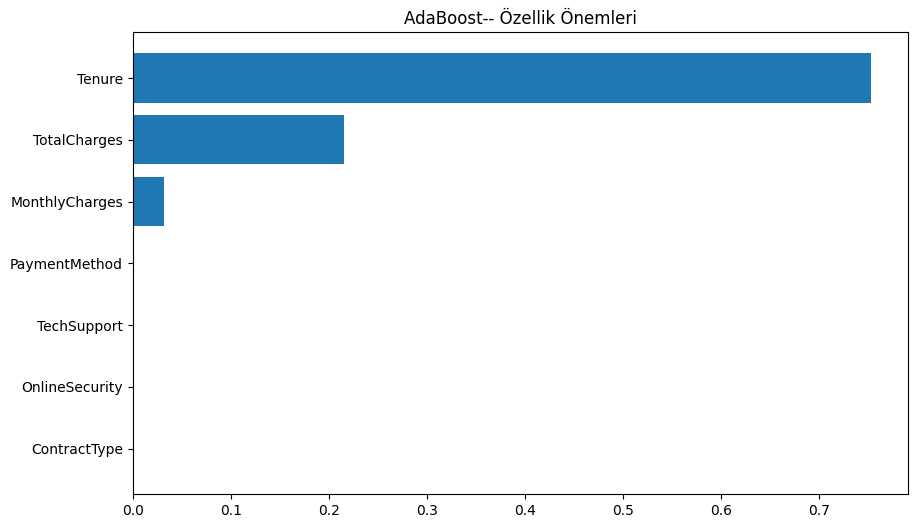

En önemli özellikler
Tenure: 0.7524
TotalCharges: 0.2155
MonthlyCharges: 0.0321


In [111]:
#Özellik önemlerini görselleştirme
feature_importance=adaboost_model.feature_importances_
sorted_idx=np.argsort(feature_importance)
plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx],align="center")
plt.yticks(range(len(sorted_idx)),X.columns[sorted_idx])
plt.title("AdaBoost-- Özellik Önemleri")
plt.show()
print("En önemli özellikler")
for i in sorted_idx[::-1][:3]:
    print(f"{X.columns[i]}: {feature_importance[i]:.4f}")


In [112]:
#Yeni bir müşteri ile tahmin yapma
new_customer={"Tenure":2,"MonthlyCharges":70,"TotalCharges":141,
              "ContractType":0,#Mont to month,
              "OnlineSecurity":0, #No
              "TechSupport":0,#No
              "PaymentMethod":0} #Electronik check
new_customer_df=pd.DataFrame([new_customer])
churn_prob=adaboost_model.predict_proba(new_customer_df)
print(churn_prob)
print(f"Yeni müşterinin churn olasılığı: {churn_prob[0,1]:.2f}")


[[0.4314967 0.5685033]]
Yeni müşterinin churn olasılığı: 0.57


# Örnek 2-) Gradient Boosting ile Emlak Fiyat Tahmini

In [113]:
#Gerçek bir emlak şirketine benzer veriler oluştur
np.random.seed(31)
area=np.random.uniform(50,300,n_samples) #metrekare
rooms=np.random.randint(1,6,n_samples) #oda sayısı
bathrooms=np.random.randint(1,3,n_samples) #banyo sayısı
age=np.random.randint(0,50,n_samples) #binanın yaşı
district=np.random.choice(["A","B","C","D"],n_samples) #semt
floor=np.random.randint(0,20,n_samples) #kaçıncı kat
has_balcony=np.random.choice([0,1],n_samples) #balkon var mı
has_parking=np.random.choice([0,1],n_samples) #park yeri var mı 

#Evin fiyatını oluşturma
base_price=100000
area_effect=area*1000
room_effect=rooms*60000
bathroom_effect=bathrooms*45000
age_effect= -age * 2000
district_effect=np.where(district=="A",50000,np.where(district=="B",30000,
                                                      np.where==(district=="C",10000,-1000)))
floor_effect=floor*500
balcony_effect=has_balcony*15000
parking_effect=has_parking*10000

price=base_price + area_effect + room_effect + bathroom_effect + age_effect + district_effect +floor_effect +balcony_effect +parking_effect

#Gerçekçi olmak için rastgelelik ekle
price=price + np.random.normal(0,20000,n_samples)

#DataFrame oluştur
data=pd.DataFrame({"Area":area,
                   "Rooms":rooms,
                   "Bathrooms":bathrooms,
                   "Age":age,
                   "District":district,
                   "Floor":floor,
                   "HasBalcony":has_balcony,
                   "HasParking":has_parking,
                   "Price":price})

#Kategorik verileri dönüştür
data["District"]=le.fit_transform(data["District"])
data

,Area,Rooms,Bathrooms,Age,District,Floor,HasBalcony,HasParking,Price
0,121.513455,5,2,14,1,14,1,0,617715.871106
1,289.526392,4,2,5,0,16,1,1,793760.044145
2,242.578233,2,2,28,3,9,1,0,502580.263769
3,296.717501,1,2,13,1,14,1,1,598191.657958
4,102.041365,1,1,22,1,0,1,0,300336.530222
...,...,...,...,...,...,...,...,...,...
995,246.729800,5,2,46,3,14,0,0,651188.566253
996,294.103058,5,2,12,0,18,0,1,808624.226450
997,127.288952,4,1,42,2,11,0,1,437080.808660
998,85.473038,5,2,8,3,15,0,0,561742.854235


In [114]:
# Değişkenleri belirle
X=data.drop("Price",axis=1)
y=data["Price"]

#Eğitim ve test verilerini böl
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=31)

#Gradient Boosting modelini oluştur
gb_model=GradientBoostingRegressor(n_estimators=100,
                                   learning_rate=0.1,
                                   max_depth=3,
                                   min_samples_split=5,
                                   min_samples_leaf=2,
                                   subsample=0.8,
                                   random_state=31)

#modeli eğit
gb_model.fit(X_train,y_train)

#tahmin yap
y_pred=gb_model.predict(X_test)

#modeli değerlendir
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
mean_price=np.mean(y_test)
print(f"Ortalama fiyat: {mean_price:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"RMSE/Ortalama Fiyat Oranı: %{(rmse/mean_price)*100:.2f}")

Ortalama fiyat: 504273.71
RMSE: 26228.26
RMSE/Ortalama Fiyat Oranı: %5.20


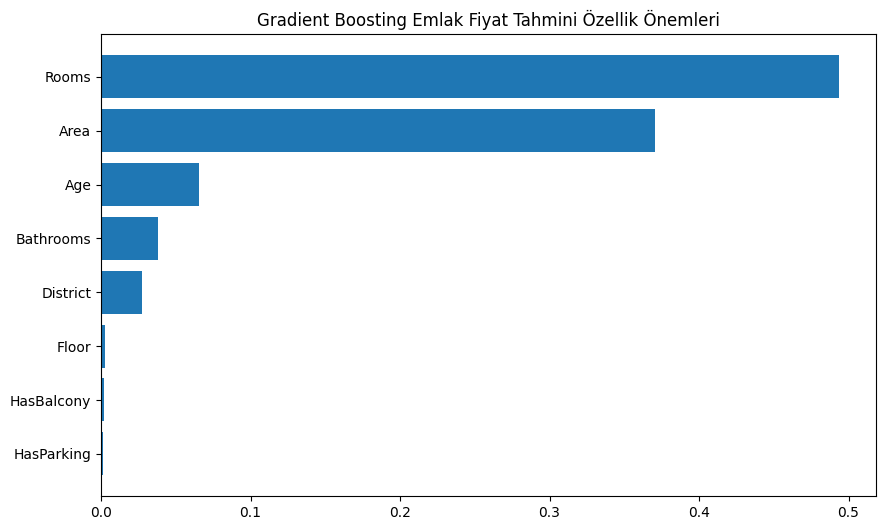

En önemli özellikler
Rooms: 0.49
Area: 0.37
Age: 0.07


In [115]:
# Özellik önemlerini görselleştirme
feature_importance=gb_model.feature_importances_
sorted_idx=np.argsort(feature_importance)
plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx],align="center")
plt.yticks(range(len(sorted_idx)),X.columns[sorted_idx])
plt.title("Gradient Boosting Emlak Fiyat Tahmini Özellik Önemleri")
plt.tight_layout
plt.show()

print("En önemli özellikler")
for i in sorted_idx[::-1][:3]:
    print(f"{X.columns[i]}: {feature_importance[i]:.2f}")

In [116]:
#Yeni emlak fiyatı için tahmin yapma(iyi bir ev için)
new_property={"Area":180,
              "Rooms":5,
              "Bathrooms":2,
              "Age":5,
              "District":le.transform(["A"])[0],
              "Floor":4,
              "HasBalcony":1,
              "HasParking":1}
new_property_df=pd.DataFrame([new_property])
predicted_price=gb_model.predict(new_property_df)[0]
print(f"Tahmin edilen fiyat: {predicted_price:.2f}")

Tahmin edilen fiyat: 705679.60


In [117]:
#Yeni emlak fiyatı için tahmin yapma(kötü bir ev için)
new_property={"Area":100,
              "Rooms":2,
              "Bathrooms":1,
              "Age":16,
              "District":le.transform(["A"])[0],
              "Floor":4,
              "HasBalcony":0,
              "HasParking":0}
new_property_df=pd.DataFrame([new_property])
predicted_price=gb_model.predict(new_property_df)[0]
print(f"Tahmin edilen fiyat: {predicted_price:.2f}")

Tahmin edilen fiyat: 363742.43


# AdaBoost vs GradientBoosting Karşılaştırma Projesi

## Örnek 3-) E-Ticaret Sitesi Müşteri Segmentasyonu

In [118]:
#Örnek veri oluşturma.(e-ticaret sitesi müşteri verileri)
np.random.seed(31)
#Müşteri özellikleri
recency=np.random.randint(1,100,n_samples) #Son alışverişten itibaren geçen gün sayısı
frequency=np.random.exponential(scale=5,size=n_samples) + 1 #Alışveriş sıklığı
monetary=np.random.exponential(scale=500,size=n_samples) + 100 #Toplam harcama
session_duration=np.random.exponential(scale=10,size=n_samples) #ORtalama oturun süresi(dakika)
pages_visited=np.random.exponential(scale=5,size=n_samples) +1 #Ziyaret edilen sayfa sayısı
cart_abandonment=np.random.binomial(1,0.3,n_samples) #Sepet terk oranı
device_type=np.random.choice(["mobile","desktop","tablet"],n_samples)
age_group=np.random.choice(["18-24","25-34","35-44","45-54","55+"],n_samples)

#Hedef: Müşteri değeri segmenti(0:Düşük, 1:Orta, 2:Yüksek)
#RFM (recency,frequency,monetary) bazlı basit segmentasyon
rfm_score=((100-recency) / 100 * 0.2 + frequency / 20 * 0.3 + monetary / 5000 * 0.5)

customer_segment=np.zeros(n_samples,dtype=int)
customer_segment[rfm_score>0.3]=1  #Orta değerli müşteriler
customer_segment[rfm_score>0.6]=2 #Yüksek değerli müşteriler

#df oluştur
data=pd.DataFrame({
    "Recency":recency,
    "Frequency":frequency,
    "Monetary":monetary,
    "SessionDuration":session_duration,
    "PagesVisited":pages_visited,
    "CartAbandonment":cart_abandonment,
    "DeviceType":device_type,
    "AgeGroup":age_group,
    "CustomerSegment":customer_segment
})
#Kategorik değişkenleri dönüştürme
le=LabelEncoder()
data["DeviceType"]=le.fit_transform(data["DeviceType"])
data["AgeGroup"]=le.fit_transform(data["AgeGroup"])
data

,Recency,Frequency,Monetary,SessionDuration,PagesVisited,CartAbandonment,DeviceType,AgeGroup,CustomerSegment
0,83,10.849040,432.512769,1.633972,2.949951,1,0,0,0
1,88,10.834240,171.640565,5.959384,8.745814,1,1,0,0
2,17,3.038684,649.755376,2.979849,9.539806,1,2,2,0
3,99,5.646193,1002.262882,26.356724,9.357951,0,2,0,0
4,24,2.217610,162.683818,2.784783,4.252345,1,1,3,0
...,...,...,...,...,...,...,...,...,...
995,61,5.281241,216.114448,36.399520,2.411247,0,0,3,0
996,61,1.261826,792.132323,44.452955,3.042879,1,1,1,0
997,87,11.712974,631.497321,6.723659,10.316422,0,0,1,0
998,3,5.678496,192.500699,9.928383,2.792217,0,0,3,0


In [119]:
#Özellik ve hedef
X=data.drop("CustomerSegment",axis=1)
y=data["CustomerSegment"]
#Eğitim ve test verilerini böl
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=31)


In [120]:
#AdaBoost Modeli
adaboost_model=AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0,
    random_state=31)

#Gradient Boosting modeli
gb_model=GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=5,
    random_state=31
)

In [121]:
#Modelleri eğitme
adaboost_model.fit(X_train,y_train)
gb_model.fit(X_train,y_train)
#Tahmin yap
ada_pred=adaboost_model.predict(X_test)
gb_pred=gb_model.predict(X_test)

In [122]:
#Modelleri Değerlendirme
print(f"AdaBoost Modeli Doğruluğu :{accuracy_score(y_test,ada_pred):.3f}")
print(f"Gradient Boosting Doğruluğu :{accuracy_score(y_test,gb_pred):.3f}")
print("------"*31)
print("------"*31)
print("AdaBoost Sınıflandırma Raporu:")
print(classification_report(y_test,ada_pred))
print("------"*31)
print("------"*31)
print("Gradient Boosting Sınıflandırma Raporu")
print(classification_report(y_test,gb_pred))

AdaBoost Modeli Doğruluğu :0.875
Gradient Boosting Doğruluğu :0.955
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
AdaBoost Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       148
           1       0.93      0.54      0.68        50
           2       0.00      0.00      0.00         2

    accuracy                           0.88       200
   macro avg       0.60      0.51      0.54       200
weighted avg       0.87      0.88      0.86       200

--------------------------------------------------------------------------------------------------------------------------------------------------

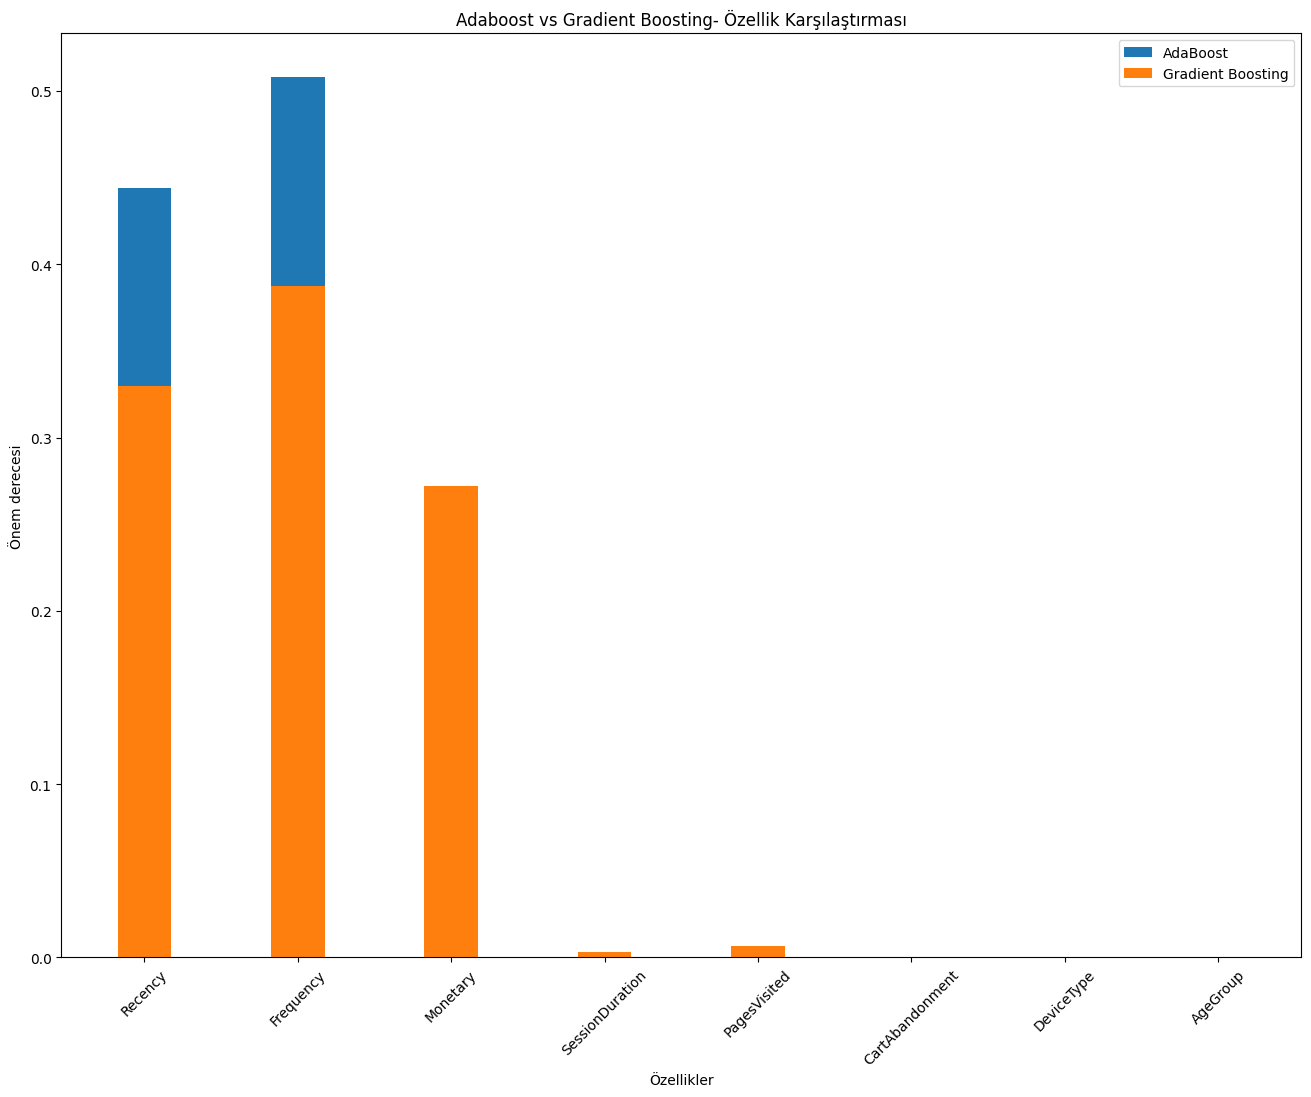

In [123]:
#Özellike önemlerini karşılaştırma
ada_importance=adaboost_model.feature_importances_
gb_importance=gb_model.feature_importances_

#En önemli özellikleri görselleştir
plt.figure(figsize=(16,12))
features=X.columns
x=np.arange(len(features))
width=0.35
plt.bar(x,ada_importance,width,label="AdaBoost")
plt.bar(x,gb_importance,width,label="Gradient Boosting")
plt.xlabel("Özellikler")
plt.ylabel("Önem derecesi")
plt.title("Adaboost vs Gradient Boosting- Özellik Karşılaştırması")
plt.xticks(x,features,rotation=45)
plt.legend()
plt.show()

In [135]:
#Tahmin için müşteri oluştur
new_customer={
    "Recency":10, #SOn 10gün içinde alışveriş yapmış
    "Frequency":15.0, #15 kez alışveriş yapmış
    "Monetary":2000.0, #2000  lira harcamış
    "SessionDuration":20.0, #Ortalama 20 dakika site ziyareti
    "PagesVisited":12.0, #Ortalama 12 sayfa ziyaret etmiş
    "CartAbandonment":0, #Sepeti hiç silmemiş
    "DeviceType":0, #Mobil cihaz
    "AgeGroup": 1 #25-34 yaş aralığında
    
    }
new_customer_df=pd.DataFrame([new_customer])
ada_segment=adaboost_model.predict(new_customer_df)[0]
gb_segment=gb_model.predict(new_customer_df)[0]
segment_names={0:"Düşük değerli",1:"Orta değerli",2:"Yüksek değerli"}
print(f"Adaboost modeline göre müşteri segmenti: {segment_names[ada_segment]}")
print(f"Gradient boosting modeline göre müşteri segmenti: {segment_names[ada_segment]}")

Adaboost modeline göre müşteri segmenti: Orta değerli
Gradient boosting modeline göre müşteri segmenti: Orta değerli


In [143]:
#İki modelin tahmin ettiği olasılıkları karşılatırma
ada_probs=adaboost_model.predict_proba(new_customer_df)[0]
gb_probs=gb_model.predict_proba(new_customer_df)[0]

print("AdaBoost olasılık dağılımı")
for i,prob in enumerate(ada_probs):
    print(f"{segment_names[i]}: {prob:.4f}")

print("-----"*31)
print("-----"*31)
print("Gradient Boosting olasılık dağılımı")
for i,prob in enumerate(gb_probs):
    print(f"{segment_names[i]}: {prob:.4f}")

AdaBoost olasılık dağılımı
Düşük değerli: 0.3574
Orta değerli: 0.3870
Yüksek değerli: 0.2556
-----------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Gradient Boosting olasılık dağılımı
Düşük değerli: 0.0000
Orta değerli: 1.0000
Yüksek değerli: 0.0000


In [144]:
ada_probs

array([0.35737407, 0.38702139, 0.25560454])

In [145]:
gb_probs

array([4.95764090e-05, 9.99950397e-01, 2.61218431e-08])

### Sonuç
* AdaBoost genellikle daha yumuşak sınır belirleme eğilimindedir ve olasılıkları daha dengeli dağıtır.
* Gradient Boosting daha keskin sınırlar çizebilir ve kararlarında daha "emin" olma eğilimindedir.